In [1]:
import torch

print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

12.8
NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
allocated_bytes = torch.cuda.memory_allocated('cuda')
allocated_mb = allocated_bytes / (1024 * 1024)

reserved_bytes = torch.cuda.memory_reserved('cuda')
reserved_mb = reserved_bytes / (1024 * 1024)

print("\n--- VRAM USAGE REPORT ---")
print(f"Memory Allocated: {allocated_mb:.2f} MB")
print(f"Memory Reserved:  {reserved_mb:.2f} MB")
print("-------------------------\n")


--- VRAM USAGE REPORT ---
Memory Allocated: 0.00 MB
Memory Reserved:  0.00 MB
-------------------------



In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

training_pipeline = A.Compose([

    A.Resize(height=224, width=224),
    A.RandomCrop(height=180, width=180, p=1.0),
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.4),

    A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), p=0.4),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.4),

    A.OneOf([
        A.GaussNoise(std_range=(0.1, 0.2), per_channel=True, p=0.4),
        A.RandomRain(slant_range=(-15, 15), drop_length=15, drop_width=1, rain_type="default", blur_value=7, p=0.4),
        A.CoarseDropout(num_holes_range=(1, 3), hole_height_range=(0.1, 0.25), hole_width_range=(0.1, 0.25), fill=0, p=0.4)
    ], p=0.5),

    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

validation_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

basic_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.6),
    A.VerticalFlip(p=0.6),
    A.Rotate(limit=(-45,45), p=0.7),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [4]:
import cv2
from torchvision import datasets

class CustomDataset(datasets.ImageFolder):

    def __getitem__(self, index):

        path, target = self.samples[index]

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, target

    def __len__(self):
        return len(self.samples)

In [5]:
import torchvision.models as models
import torch.nn as nn

class PestClassifierMobileNetV2(nn.Module):

    def __init__(self, num_classes):
        super(PestClassifierMobileNetV2, self).__init__()

        # get model
        self.base_model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')

        # Froze feature extraction layer to retain weights.
        for params in self.base_model.parameters():
            params.requires_grad = False

        # get number of features
        num_filters = self.base_model.classifier[1].in_features

        # Hyperparameter tuning: new layer for 6 rice pests.
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True),
            nn.Linear(num_filters, num_classes),
        )

    # Forward propagation
    def forward(self, x):

       features = self.base_model.features(x)

       features = F.adaptive_avg_pool2d(features, output_size=(1, 1)).reshape(features.shape[0], -1)

       features = self.base_model.classifier(features)

       return features

    def unfreeze_layer(self, layer):

        if not (1 <= layer <= len(self.base_model.features)):
            print(f"Error: Invalid layer index {layer}.")
            return

        # Corrected print statement
        print(f"\nUnfreezing feature layer at index: -{layer}")

        for param in self.base_model.features[-layer].parameters():
            param.requires_grad = True


In [7]:
class PestClassifierEfficientNetV2M(nn.Module):

    def __init__(self, num_classes):
        super(PestClassifierEfficientNetV2M, self).__init__()

        self.base_model = models.efficientnet_v2_m(weights='EfficientNet_V2_M_Weights.IMAGENET1K_V1')

        for params in self.base_model.parameters():
            params.requires_grad = False

        features = self.base_model.classifier[1].in_features

        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(features, num_classes),
        )

    def forward(self, x):

        features = self.base_model.features(x)

        features = F.adaptive_avg_pool2d(features, output_size=(1, 1)).reshape(features.shape[0], -1)

        features = self.base_model.classifier(features)

        return features

    def unfreeze_layer(self, layer):

        if not (1 <= layer <= len(self.base_model.features)):
            print(f"Error: Invalid layer index {layer}.")
            return

        print(f"\nUnfreezing feature layer at index: -{layer}")

        for params in self.base_model.features[-layer].parameters():
            params.requires_grad = True


In [24]:
class PestClassifierEfficientNetV2S(nn.Module):

    def __init__(self, num_classes):

        super(PestClassifierEfficientNetV2S, self).__init__()

        self.base_model = models.efficientnet_v2_s(weights='EfficientNet_V2_S_Weights.IMAGENET1K_V1')

        for params in self.base_model.parameters():
            params.requires_grad = False

        features = self.base_model.classifier[1].in_features

        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(features, num_classes),
        )

    def forward(self, x):

        features = self.base_model.features(x)

        features = F.adaptive_avg_pool2d(features, output_size=(1,1)).reshape(features.shape[0], -1)

        features = self.base_model.classifier(features)

        return features

    def unfreeze_layer(self, layer):

        if not (1 <= layer <= len(self.base_model.features)):
            print(f"Error: Invalid layer index {layer}.")

        print(f"\nUnfreezing feature layer at index: -{layer}")

        for params in self.base_model.features[-layer].parameters():
            params.requires_grad = True



In [23]:
model = models.efficientnet_v2_s(weights='EfficientNet_V2_S_Weights.IMAGENET1K_V1')

print(model)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to C:\Users\LANCE/.cache\torch\hub\checkpoints\efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:26<00:00, 3.27MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [8]:
import torch
from tqdm import tqdm

def train_and_validate(model, optimizer, criterion, train_dataloader, validation_dataloader, num_epoch, device, scheduler, patience=3, min_delta=0.001):

    train_losses = []
    validation_losses = []
    accuracies = []
    patience_counter = 0
    best_validation_loss=float('inf')
    best_session_accuracy = float('inf')
    stop_early=False
    fully_stop = False

    for epoch in range(num_epoch):
        model.train()
        running_train_loss = 0.0
        train_pbar = tqdm(train_dataloader, desc=f"Train epoch: {epoch+1}")
        for data, labels in train_pbar:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        training_loss = running_train_loss / len(train_dataloader)
        train_losses.append(training_loss)

        model.eval()
        running_eval_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in tqdm(validation_dataloader, desc=f"Validate Epoch {epoch+1}"):
                inputs, labels = inputs.to(device), labels.to(device)

                logits = model(inputs)
                loss = criterion(logits, labels)
                running_eval_loss += loss.item()
                _, predicted = torch.max(logits.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        validation_loss = running_eval_loss / len(validation_dataloader)
        validation_losses.append(validation_loss)
        accuracy = 100 * correct_predictions / total_samples
        accuracies.append(accuracy)

        scheduler.step(validation_loss)

        current_lr = optimizer.param_groups[0]['lr']
        epoch_summary = f'Epoch {epoch+1}/{num_epoch} |lr: {current_lr}| Train Loss: {training_loss:.4f} | Evaluate Loss: {validation_loss:.4f} | Accuracy: {accuracy:.2f}%'

        if device.type == 'cuda':
            allocated_gb = torch.cuda.memory_allocated() / (1024 ** 3)
            reserved_gb = torch.cuda.memory_reserved() / (1024 ** 3)
            epoch_summary += f' | GPU Memory (Alloc/Reserved): {allocated_gb:.2f}/{reserved_gb:.2f} GB'

        tqdm.write(epoch_summary)

        if validation_loss < best_validation_loss - min_delta:

            patience_counter = 0
            best_validation_loss = validation_loss
            torch.save(model.state_dict(), 'models/EfficientNetV2/SEfficientNetV2-m_rice_pest_classificationV13.pt')
        else:
            patience_counter += 1
            tqdm.write(f'No improvement for {patience_counter}/{patience} epochs')

        if  validation_loss >= training_loss:
            tqdm.write(f'Training stopped! Validation loss: {validation_loss:.4f} | Training loss: {training_loss:.4f}')
            fully_stop = True
            break

        if patience_counter >= patience:
            tqdm.write(f'Early stopping triggered after {patience_counter} epochs')
            stop_early = True
            break

    tqdm.write('Session complete')

    return {'train_loss': train_losses, 'validation_loss': validation_losses, 'accuracy': accuracies}, best_session_accuracy, stop_early, fully_stop

<h2>  Saving and plott</h2>

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

def plot_training_result(*results):

    full_training_loss = []
    full_validation_loss = []

    for result in results:
        train_loss = result.get('train_loss', [])
        full_training_loss.extend(train_loss)
        full_validation_loss.extend(result.get('validation_loss', []))

    total_epochs = len(full_training_loss)

    if total_epochs == 0:
        print("No data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    data = {
        'Epoch': epochs,
        'Training Loss': full_training_loss,
        'Validation Loss': full_validation_loss,
    }

    df = pd.DataFrame(data)

    df_long = df.melt(id_vars=['Epoch'], var_name='Loss Type', value_name='Loss')

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_long, x='Epoch', y='Loss', hue='Loss Type', marker='o')

    plt.title('Training and Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_historical_results(file_name):

    data = pd.read_csv(file_name)

    df = pd.DataFrame(data)

    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    fig.suptitle('Training and Validation Loss Comparison', fontsize=16)

    historical_losses = df.melt(id_vars=['epoch'],value_vars=['train_loss', 'validation_loss'], var_name='Loss Type', value_name='Loss')

    sns.lineplot(data=historical_losses, hue='Loss Type', markers='o' ,x='epoch' , y='Loss', ax=axes[0])

    axes[0].set_title('Training and Validation Loss Comparison')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)
    axes[0].legend()

    sns.lineplot(data=df, x='epoch', y='accuracy', color='g', markers='o', ax=axes[1])
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].grid(True)

    plt.tight_layout(rect=(0, 0.03, 1, 0.95))

    plt.show()

def plot_accuracy(*results):

    full_accuracy = []

    for res in results:
        accuracy = res.get('accuracy', [])
        full_accuracy.extend(accuracy)

    total_epochs = len(full_accuracy)

    if total_epochs == 0:
        print("No accuracy data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    plt.figure(figsize=(10, 6))

    plt.plot(epochs, full_accuracy, label='Accuracy', marker='o', color='g')

    plt.title('Accuracy Evaluation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

def save_historical_data(history, filename='training_results\EfficientNetV2\SEfficientNetV2-m_rice_pest_classificationV13.csv'):

    training_loss = history.get('train_loss', [])
    test_loss = history.get('validation_loss', [])
    accuracy = history.get('accuracy', [])

    data_dict = pd.DataFrame({
        'train_loss': training_loss,
        'validation_loss': test_loss,
        'accuracy': accuracy,
    })

    if os.path.exists(filename):
        print("historical data exists! Appending new data.")
        old_data = pd.read_csv(filename)
        combined_data = pd.concat([old_data, data_dict], ignore_index=True)

    else:
        print("Creating new historical data...")
        combined_data = data_dict

    combined_data['epoch'] = range(1, len(combined_data) + 1)

    combined_data = combined_data[['epoch', 'train_loss', 'validation_loss', 'accuracy']]

    combined_data.to_csv(filename, index=False)

    print("Historical data saved successfully!")



In [11]:
from torch.utils.data import DataLoader

train_set = CustomDataset(root='datasets/train', transform=training_pipeline)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
validation_set = CustomDataset(root='datasets/test', transform=validation_pipeline)
validation_loader = DataLoader(validation_set, batch_size=64, shuffle=True)
test_set = CustomDataset(root='datasets/val', transform=validation_pipeline)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

classes = train_set.classes

In [13]:
from torch.optim import lr_scheduler

def incremental_training(model, sessions, criterion, train_dataloader, validation_dataloader, device):

    full_history = []
    best_overall_accuracy = 0.0

    for i, session in enumerate(sessions):
        print(f"\n--- Starting Training Session {i+1}/{len(sessions)} ---")

        epochs = session['epochs']
        lr = session['lr']
        layer_to_unfreeze = session.get('unfreeze_layer', 0)

        if layer_to_unfreeze > 0:
            model.unfreeze_layer(layer_to_unfreeze)

        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-2)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.5, mode='min', patience=2, min_lr=1e-7)

        session_history, session_best_accuracy, stop_early, full_stop = train_and_validate(
            model, optimizer, criterion, train_dataloader, validation_dataloader,
            epochs, device, scheduler
        )

        full_history.append(session_history)
        save_historical_data(session_history)

        if session_best_accuracy > best_overall_accuracy:
            best_overall_accuracy = session_best_accuracy

        if full_stop:
            print("Full stop triggered! possible overfitting in further sessions.")
            break

        if stop_early:
            print("Early stopping triggered. Moving to next session or finishing training.")

    print(f"\n--- Incremental training finished. Best overall accuracy: {best_overall_accuracy:.2f}% ---")
    return full_history


In [18]:
import torch.optim as optim

hardware = torch.device('cuda' if  torch.cuda.is_available() else 'cpu')
classes = 6
learning_rate = 1e-3
weight_decay = 1e-2
criterion = nn.CrossEntropyLoss()

model = PestClassifierEfficientNetV2M(num_classes=classes).to(hardware)

training_sessions = [

    {'epochs': 20, 'lr': 5e-4, 'unfreeze_layer': 0},

    {'epochs': 30, 'lr': 1e-4, 'unfreeze_layer': 1},

    {'epochs': 40, 'lr': 5e-5, 'unfreeze_layer': 2},

    {'epochs': 50, 'lr': 1e-5, 'unfreeze_layer': 3},

]

result, accuracies = incremental_training(model=model, sessions=training_sessions, criterion=criterion, train_dataloader=train_loader, validation_dataloader=validation_loader, device=hardware)

plot_training_result(*result)
plot_accuracy(*result)


--- Starting Training Session 1/4 ---


Validate Epoch 1: 100%|██████████| 34/34 [00:11<00:00,  3.03it/s]


Epoch 1/20 |lr: 0.0005| Train Loss: 1.5051 | Evaluate Loss: 1.1779 | Accuracy: 64.12% | GPU Memory (Alloc/Reserved): 0.45/1.75 GB


Validate Epoch 2: 100%|██████████| 34/34 [00:10<00:00,  3.34it/s]


Epoch 2/20 |lr: 0.0005| Train Loss: 1.2325 | Evaluate Loss: 0.9796 | Accuracy: 69.37% | GPU Memory (Alloc/Reserved): 0.45/1.75 GB


Validate Epoch 3: 100%|██████████| 34/34 [00:10<00:00,  3.37it/s]


Epoch 3/20 |lr: 0.0005| Train Loss: 1.1271 | Evaluate Loss: 0.8786 | Accuracy: 71.90% | GPU Memory (Alloc/Reserved): 0.45/1.75 GB


Validate Epoch 4: 100%|██████████| 34/34 [00:10<00:00,  3.34it/s]


Epoch 4/20 |lr: 0.0005| Train Loss: 1.0471 | Evaluate Loss: 0.8158 | Accuracy: 73.36% | GPU Memory (Alloc/Reserved): 0.45/1.75 GB


Validate Epoch 5: 100%|██████████| 34/34 [00:10<00:00,  3.31it/s]


Epoch 5/20 |lr: 0.0005| Train Loss: 1.0061 | Evaluate Loss: 0.7668 | Accuracy: 75.23% | GPU Memory (Alloc/Reserved): 0.45/1.75 GB


Validate Epoch 6: 100%|██████████| 34/34 [00:10<00:00,  3.33it/s]


Epoch 6/20 |lr: 0.0005| Train Loss: 0.9746 | Evaluate Loss: 0.7409 | Accuracy: 74.62% | GPU Memory (Alloc/Reserved): 0.45/1.75 GB


Validate Epoch 7: 100%|██████████| 34/34 [00:10<00:00,  3.30it/s]


Epoch 7/20 |lr: 0.0005| Train Loss: 0.9524 | Evaluate Loss: 0.7157 | Accuracy: 75.66% | GPU Memory (Alloc/Reserved): 0.45/1.75 GB


Validate Epoch 8: 100%|██████████| 34/34 [00:10<00:00,  3.31it/s]


Epoch 8/20 |lr: 0.0005| Train Loss: 0.9367 | Evaluate Loss: 0.6903 | Accuracy: 76.55% | GPU Memory (Alloc/Reserved): 0.45/1.75 GB


Validate Epoch 9: 100%|██████████| 34/34 [00:10<00:00,  3.31it/s]


Epoch 9/20 |lr: 0.0005| Train Loss: 0.9280 | Evaluate Loss: 0.6833 | Accuracy: 76.41% | GPU Memory (Alloc/Reserved): 0.45/1.75 GB


Validate Epoch 10: 100%|██████████| 34/34 [00:10<00:00,  3.32it/s]


Epoch 10/20 |lr: 0.0005| Train Loss: 0.9239 | Evaluate Loss: 0.6665 | Accuracy: 76.69% | GPU Memory (Alloc/Reserved): 0.45/1.75 GB


Validate Epoch 11: 100%|██████████| 34/34 [00:10<00:00,  3.32it/s]


Epoch 11/20 |lr: 0.0005| Train Loss: 0.9157 | Evaluate Loss: 0.6567 | Accuracy: 77.16% | GPU Memory (Alloc/Reserved): 0.45/1.75 GB


Validate Epoch 12: 100%|██████████| 34/34 [00:10<00:00,  3.30it/s]


Epoch 12/20 |lr: 0.0005| Train Loss: 0.8950 | Evaluate Loss: 0.6419 | Accuracy: 77.49% | GPU Memory (Alloc/Reserved): 0.45/1.75 GB


Validate Epoch 13: 100%|██████████| 34/34 [00:10<00:00,  3.30it/s]


Epoch 13/20 |lr: 0.0005| Train Loss: 0.8982 | Evaluate Loss: 0.6478 | Accuracy: 77.16% | GPU Memory (Alloc/Reserved): 0.45/1.75 GB
No improvement for 1/3 epochs


Validate Epoch 14: 100%|██████████| 34/34 [00:10<00:00,  3.28it/s]


Epoch 14/20 |lr: 0.0005| Train Loss: 0.8945 | Evaluate Loss: 0.6380 | Accuracy: 77.91% | GPU Memory (Alloc/Reserved): 0.45/1.75 GB


Validate Epoch 15: 100%|██████████| 34/34 [00:10<00:00,  3.32it/s]


Epoch 15/20 |lr: 0.0005| Train Loss: 0.8697 | Evaluate Loss: 0.6196 | Accuracy: 78.71% | GPU Memory (Alloc/Reserved): 0.45/1.75 GB


Validate Epoch 16: 100%|██████████| 34/34 [00:10<00:00,  3.30it/s]


Epoch 16/20 |lr: 0.0005| Train Loss: 0.8838 | Evaluate Loss: 0.6150 | Accuracy: 78.52% | GPU Memory (Alloc/Reserved): 0.45/1.75 GB


Validate Epoch 17: 100%|██████████| 34/34 [00:10<00:00,  3.29it/s]


Epoch 17/20 |lr: 0.0005| Train Loss: 0.8783 | Evaluate Loss: 0.6084 | Accuracy: 78.85% | GPU Memory (Alloc/Reserved): 0.45/1.75 GB


Validate Epoch 18: 100%|██████████| 34/34 [00:10<00:00,  3.30it/s]


Epoch 18/20 |lr: 0.0005| Train Loss: 0.8717 | Evaluate Loss: 0.6074 | Accuracy: 78.85% | GPU Memory (Alloc/Reserved): 0.45/1.75 GB


Validate Epoch 19: 100%|██████████| 34/34 [00:10<00:00,  3.33it/s]


Epoch 19/20 |lr: 0.0005| Train Loss: 0.8753 | Evaluate Loss: 0.5974 | Accuracy: 78.89% | GPU Memory (Alloc/Reserved): 0.45/1.75 GB


Validate Epoch 20: 100%|██████████| 34/34 [00:10<00:00,  3.31it/s]


Epoch 20/20 |lr: 0.0005| Train Loss: 0.8664 | Evaluate Loss: 0.6014 | Accuracy: 79.27% | GPU Memory (Alloc/Reserved): 0.45/1.75 GB
No improvement for 1/3 epochs
Session complete
Creating new historical data...
Historical data saved successfully!

--- Starting Training Session 2/4 ---

Unfreezing feature layer at index: -1


Validate Epoch 1: 100%|██████████| 34/34 [00:10<00:00,  3.35it/s]


Epoch 1/30 |lr: 0.0001| Train Loss: 0.8425 | Evaluate Loss: 0.5578 | Accuracy: 80.11% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 2: 100%|██████████| 34/34 [00:10<00:00,  3.30it/s]


Epoch 2/30 |lr: 0.0001| Train Loss: 0.8168 | Evaluate Loss: 0.5559 | Accuracy: 80.16% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 3: 100%|██████████| 34/34 [00:10<00:00,  3.32it/s]


Epoch 3/30 |lr: 0.0001| Train Loss: 0.7802 | Evaluate Loss: 0.5267 | Accuracy: 81.19% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 4: 100%|██████████| 34/34 [00:10<00:00,  3.35it/s]


Epoch 4/30 |lr: 0.0001| Train Loss: 0.7727 | Evaluate Loss: 0.4984 | Accuracy: 82.18% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 5: 100%|██████████| 34/34 [00:10<00:00,  3.34it/s]


Epoch 5/30 |lr: 0.0001| Train Loss: 0.7466 | Evaluate Loss: 0.4918 | Accuracy: 82.69% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 6: 100%|██████████| 34/34 [00:12<00:00,  2.72it/s]


Epoch 6/30 |lr: 0.0001| Train Loss: 0.7203 | Evaluate Loss: 0.4864 | Accuracy: 82.83% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 7: 100%|██████████| 34/34 [00:10<00:00,  3.29it/s]


Epoch 7/30 |lr: 0.0001| Train Loss: 0.7260 | Evaluate Loss: 0.4803 | Accuracy: 83.07% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 8: 100%|██████████| 34/34 [00:09<00:00,  3.40it/s]


Epoch 8/30 |lr: 0.0001| Train Loss: 0.7160 | Evaluate Loss: 0.4558 | Accuracy: 84.15% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 9: 100%|██████████| 34/34 [00:10<00:00,  3.39it/s]


Epoch 9/30 |lr: 0.0001| Train Loss: 0.7129 | Evaluate Loss: 0.4540 | Accuracy: 84.01% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 10: 100%|██████████| 34/34 [00:10<00:00,  3.40it/s]


Epoch 10/30 |lr: 0.0001| Train Loss: 0.6978 | Evaluate Loss: 0.4436 | Accuracy: 84.10% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 11: 100%|██████████| 34/34 [00:10<00:00,  3.39it/s]


Epoch 11/30 |lr: 0.0001| Train Loss: 0.6811 | Evaluate Loss: 0.4430 | Accuracy: 84.43% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB
No improvement for 1/3 epochs


Validate Epoch 12: 100%|██████████| 34/34 [00:10<00:00,  3.32it/s]


Epoch 12/30 |lr: 0.0001| Train Loss: 0.6810 | Evaluate Loss: 0.4388 | Accuracy: 84.85% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 13: 100%|██████████| 34/34 [00:10<00:00,  3.36it/s]


Epoch 13/30 |lr: 0.0001| Train Loss: 0.6710 | Evaluate Loss: 0.4370 | Accuracy: 84.62% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 14: 100%|██████████| 34/34 [00:10<00:00,  3.32it/s]


Epoch 14/30 |lr: 0.0001| Train Loss: 0.6491 | Evaluate Loss: 0.4240 | Accuracy: 85.18% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 15: 100%|██████████| 34/34 [00:10<00:00,  3.32it/s]


Epoch 15/30 |lr: 0.0001| Train Loss: 0.6690 | Evaluate Loss: 0.4262 | Accuracy: 85.18% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB
No improvement for 1/3 epochs


Validate Epoch 16: 100%|██████████| 34/34 [00:10<00:00,  3.33it/s]


Epoch 16/30 |lr: 0.0001| Train Loss: 0.6645 | Evaluate Loss: 0.4220 | Accuracy: 85.37% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 17: 100%|██████████| 34/34 [00:10<00:00,  3.35it/s]


Epoch 17/30 |lr: 0.0001| Train Loss: 0.6484 | Evaluate Loss: 0.4175 | Accuracy: 85.83% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 18: 100%|██████████| 34/34 [00:10<00:00,  3.37it/s]


Epoch 18/30 |lr: 0.0001| Train Loss: 0.6617 | Evaluate Loss: 0.4090 | Accuracy: 86.02% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 19: 100%|██████████| 34/34 [00:10<00:00,  3.32it/s]


Epoch 19/30 |lr: 0.0001| Train Loss: 0.6253 | Evaluate Loss: 0.4049 | Accuracy: 86.07% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 20: 100%|██████████| 34/34 [00:09<00:00,  3.41it/s]


Epoch 20/30 |lr: 0.0001| Train Loss: 0.6187 | Evaluate Loss: 0.4018 | Accuracy: 86.49% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 21: 100%|██████████| 34/34 [00:10<00:00,  3.39it/s]


Epoch 21/30 |lr: 0.0001| Train Loss: 0.6232 | Evaluate Loss: 0.3979 | Accuracy: 86.68% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 22: 100%|██████████| 34/34 [00:10<00:00,  3.40it/s]


Epoch 22/30 |lr: 0.0001| Train Loss: 0.6174 | Evaluate Loss: 0.3885 | Accuracy: 86.87% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 23: 100%|██████████| 34/34 [00:10<00:00,  3.37it/s]


Epoch 23/30 |lr: 0.0001| Train Loss: 0.6155 | Evaluate Loss: 0.3946 | Accuracy: 86.77% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB
No improvement for 1/3 epochs


Validate Epoch 24: 100%|██████████| 34/34 [00:09<00:00,  3.41it/s]


Epoch 24/30 |lr: 0.0001| Train Loss: 0.6216 | Evaluate Loss: 0.3859 | Accuracy: 87.20% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 25: 100%|██████████| 34/34 [00:10<00:00,  3.36it/s]


Epoch 25/30 |lr: 0.0001| Train Loss: 0.6033 | Evaluate Loss: 0.3840 | Accuracy: 87.57% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 26: 100%|██████████| 34/34 [00:10<00:00,  3.33it/s]


Epoch 26/30 |lr: 0.0001| Train Loss: 0.6058 | Evaluate Loss: 0.3774 | Accuracy: 87.48% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 27: 100%|██████████| 34/34 [00:10<00:00,  3.35it/s]


Epoch 27/30 |lr: 0.0001| Train Loss: 0.6116 | Evaluate Loss: 0.3744 | Accuracy: 87.62% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 28: 100%|██████████| 34/34 [00:10<00:00,  3.33it/s]


Epoch 28/30 |lr: 0.0001| Train Loss: 0.5921 | Evaluate Loss: 0.3764 | Accuracy: 87.38% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB
No improvement for 1/3 epochs


Validate Epoch 29: 100%|██████████| 34/34 [00:10<00:00,  3.39it/s]


Epoch 29/30 |lr: 0.0001| Train Loss: 0.6016 | Evaluate Loss: 0.3652 | Accuracy: 87.57% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB


Validate Epoch 30: 100%|██████████| 34/34 [00:10<00:00,  3.40it/s]


Epoch 30/30 |lr: 0.0001| Train Loss: 0.5948 | Evaluate Loss: 0.3736 | Accuracy: 87.38% | GPU Memory (Alloc/Reserved): 0.46/1.75 GB
No improvement for 1/3 epochs
Session complete
historical data exists! Appending new data.
Historical data saved successfully!

--- Starting Training Session 3/4 ---

Unfreezing feature layer at index: -2


Validate Epoch 1: 100%|██████████| 34/34 [00:10<00:00,  3.29it/s]


Epoch 1/40 |lr: 5e-05| Train Loss: 0.5316 | Evaluate Loss: 0.3003 | Accuracy: 90.10% | GPU Memory (Alloc/Reserved): 0.66/3.87 GB


Validate Epoch 2: 100%|██████████| 34/34 [00:15<00:00,  2.25it/s]


Epoch 2/40 |lr: 5e-05| Train Loss: 0.4290 | Evaluate Loss: 0.2569 | Accuracy: 91.14% | GPU Memory (Alloc/Reserved): 0.66/3.87 GB


Validate Epoch 3: 100%|██████████| 34/34 [00:13<00:00,  2.44it/s]


Epoch 3/40 |lr: 5e-05| Train Loss: 0.3809 | Evaluate Loss: 0.2640 | Accuracy: 92.03% | GPU Memory (Alloc/Reserved): 0.66/3.87 GB
No improvement for 1/3 epochs


Validate Epoch 4: 100%|██████████| 34/34 [00:10<00:00,  3.38it/s]


Epoch 4/40 |lr: 5e-05| Train Loss: 0.3559 | Evaluate Loss: 0.2166 | Accuracy: 92.45% | GPU Memory (Alloc/Reserved): 0.66/3.87 GB


Validate Epoch 5: 100%|██████████| 34/34 [00:10<00:00,  3.20it/s]


Epoch 5/40 |lr: 5e-05| Train Loss: 0.3235 | Evaluate Loss: 0.2048 | Accuracy: 93.53% | GPU Memory (Alloc/Reserved): 0.66/3.87 GB


Validate Epoch 6: 100%|██████████| 34/34 [00:10<00:00,  3.40it/s]


Epoch 6/40 |lr: 5e-05| Train Loss: 0.2953 | Evaluate Loss: 0.1997 | Accuracy: 93.53% | GPU Memory (Alloc/Reserved): 0.66/3.87 GB


Validate Epoch 7: 100%|██████████| 34/34 [00:09<00:00,  3.44it/s]


Epoch 7/40 |lr: 5e-05| Train Loss: 0.2718 | Evaluate Loss: 0.2068 | Accuracy: 93.48% | GPU Memory (Alloc/Reserved): 0.66/3.87 GB
No improvement for 1/3 epochs


Validate Epoch 8: 100%|██████████| 34/34 [00:10<00:00,  3.36it/s]


Epoch 8/40 |lr: 5e-05| Train Loss: 0.2600 | Evaluate Loss: 0.1789 | Accuracy: 94.23% | GPU Memory (Alloc/Reserved): 0.66/3.87 GB


Validate Epoch 9: 100%|██████████| 34/34 [00:10<00:00,  3.38it/s]


Epoch 9/40 |lr: 5e-05| Train Loss: 0.2432 | Evaluate Loss: 0.1824 | Accuracy: 94.51% | GPU Memory (Alloc/Reserved): 0.66/3.87 GB
No improvement for 1/3 epochs


Validate Epoch 10: 100%|██████████| 34/34 [00:10<00:00,  3.18it/s]


Epoch 10/40 |lr: 5e-05| Train Loss: 0.2344 | Evaluate Loss: 0.1921 | Accuracy: 94.28% | GPU Memory (Alloc/Reserved): 0.66/3.87 GB
No improvement for 2/3 epochs


Validate Epoch 11: 100%|██████████| 34/34 [00:11<00:00,  3.02it/s]


Epoch 11/40 |lr: 5e-05| Train Loss: 0.2277 | Evaluate Loss: 0.1758 | Accuracy: 94.84% | GPU Memory (Alloc/Reserved): 0.66/3.87 GB


Validate Epoch 12: 100%|██████████| 34/34 [00:10<00:00,  3.24it/s]


Epoch 12/40 |lr: 5e-05| Train Loss: 0.2178 | Evaluate Loss: 0.1742 | Accuracy: 94.84% | GPU Memory (Alloc/Reserved): 0.66/3.87 GB


Validate Epoch 13: 100%|██████████| 34/34 [00:10<00:00,  3.31it/s]


Epoch 13/40 |lr: 5e-05| Train Loss: 0.2023 | Evaluate Loss: 0.1658 | Accuracy: 95.17% | GPU Memory (Alloc/Reserved): 0.66/3.87 GB


Validate Epoch 14: 100%|██████████| 34/34 [00:10<00:00,  3.34it/s]


Epoch 14/40 |lr: 5e-05| Train Loss: 0.1969 | Evaluate Loss: 0.1743 | Accuracy: 94.79% | GPU Memory (Alloc/Reserved): 0.66/3.87 GB
No improvement for 1/3 epochs


Validate Epoch 15: 100%|██████████| 34/34 [00:10<00:00,  3.32it/s]


Epoch 15/40 |lr: 5e-05| Train Loss: 0.1832 | Evaluate Loss: 0.1767 | Accuracy: 94.79% | GPU Memory (Alloc/Reserved): 0.66/3.87 GB
No improvement for 2/3 epochs


Validate Epoch 16: 100%|██████████| 34/34 [00:10<00:00,  3.32it/s]


Epoch 16/40 |lr: 2.5e-05| Train Loss: 0.1894 | Evaluate Loss: 0.1778 | Accuracy: 95.17% | GPU Memory (Alloc/Reserved): 0.66/3.87 GB
No improvement for 3/3 epochs
Early stopping triggered after 3 epochs
Session complete
historical data exists! Appending new data.
Historical data saved successfully!
Early stopping triggered. Moving to next session or finishing training.

--- Starting Training Session 4/4 ---

Unfreezing feature layer at index: -3


Validate Epoch 1: 100%|██████████| 34/34 [00:11<00:00,  2.92it/s]


Epoch 1/50 |lr: 1e-05| Train Loss: 0.1751 | Evaluate Loss: 0.1767 | Accuracy: 95.12% | GPU Memory (Alloc/Reserved): 0.96/10.44 GB
Training stopped! Validation loss: 0.1767 | Training loss: 0.1751


Validate Epoch 2: 100%|██████████| 34/34 [00:12<00:00,  2.71it/s]


Epoch 2/50 |lr: 1e-05| Train Loss: 0.1515 | Evaluate Loss: 0.1706 | Accuracy: 95.26% | GPU Memory (Alloc/Reserved): 0.96/10.44 GB
Training stopped! Validation loss: 0.1706 | Training loss: 0.1515


Validate Epoch 3: 100%|██████████| 34/34 [00:16<00:00,  2.04it/s]


Epoch 3/50 |lr: 1e-05| Train Loss: 0.1518 | Evaluate Loss: 0.1793 | Accuracy: 95.17% | GPU Memory (Alloc/Reserved): 0.95/10.44 GB
No improvement for 1/3 epochs
Training stopped! Validation loss: 0.1793 | Training loss: 0.1518


Validate Epoch 4: 100%|██████████| 34/34 [00:21<00:00,  1.57it/s]


Epoch 4/50 |lr: 1e-05| Train Loss: 0.1516 | Evaluate Loss: 0.1715 | Accuracy: 95.40% | GPU Memory (Alloc/Reserved): 0.95/10.44 GB
No improvement for 2/3 epochs
Training stopped! Validation loss: 0.1715 | Training loss: 0.1516


Validate Epoch 5: 100%|██████████| 34/34 [00:17<00:00,  1.95it/s]


Epoch 5/50 |lr: 5e-06| Train Loss: 0.1356 | Evaluate Loss: 0.1746 | Accuracy: 95.17% | GPU Memory (Alloc/Reserved): 0.95/10.44 GB
No improvement for 3/3 epochs
Training stopped! Validation loss: 0.1746 | Training loss: 0.1356
Early stopping triggered after 3 epochs
Session complete
historical data exists! Appending new data.
Historical data saved successfully!
Full stop triggered! possible overfitting in further sessions.

--- Incremental training finished. Best overall accuracy: inf% ---


ValueError: too many values to unpack (expected 2)

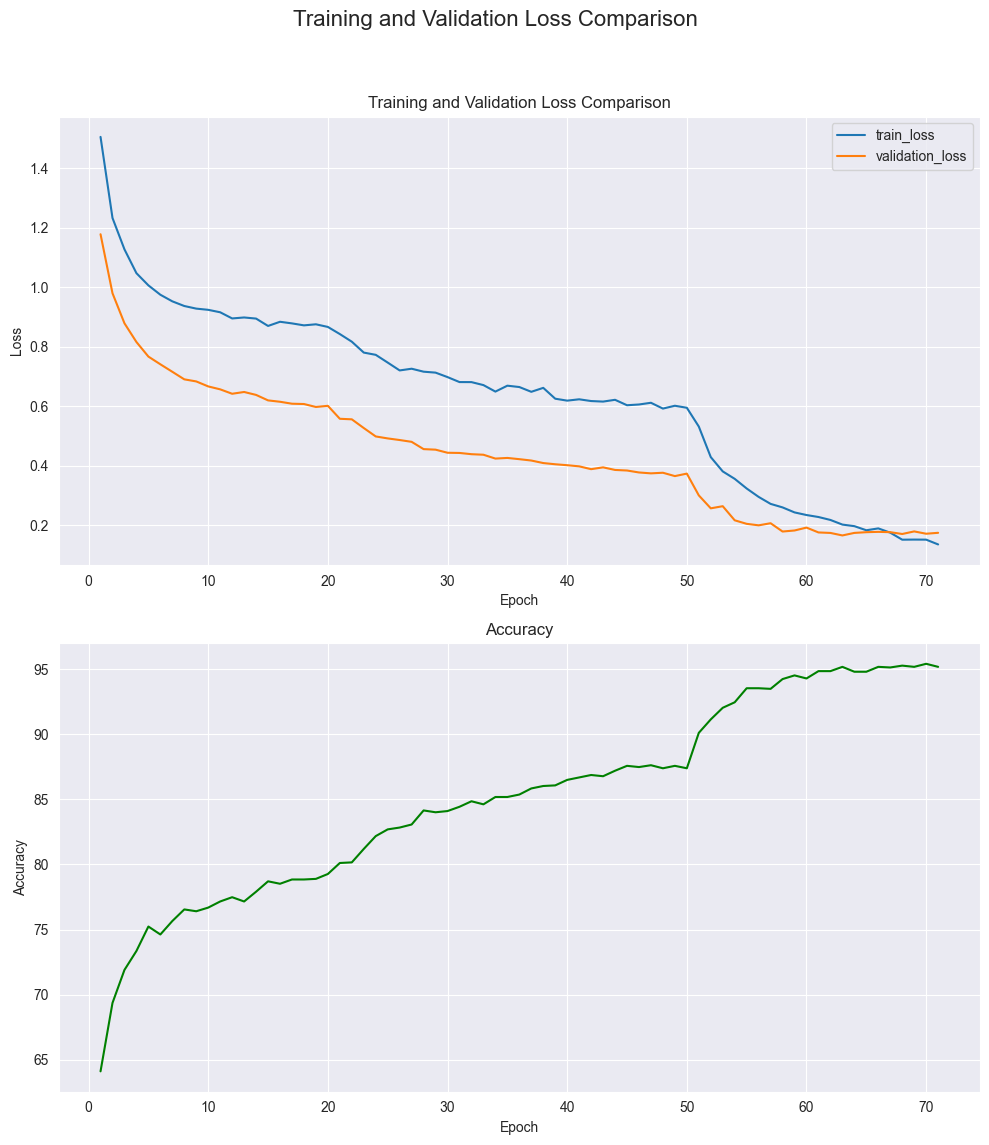

In [22]:
plot_historical_results('training_results\EfficientNetV2\SEfficientNetV2-m_rice_pest_classificationV13.csv')

In [ ]:
import torch.optim as optim

hardware = torch.device('cuda' if  torch.cuda.is_available() else 'cpu')
classes = 6
criterion = nn.CrossEntropyLoss()

model = PestClassifierMobileNetV2(num_classes=classes).to(hardware)

training_sessions = [

    {'epochs': 15, 'lr': 5e-4, 'unfreeze_layer': 0},

    {'epochs': 25, 'lr': 1e-4, 'unfreeze_layer': 1},

    {'epochs': 35, 'lr': 5e-5, 'unfreeze_layer': 2},

    {'epochs': 45, 'lr': 1e-5, 'unfreeze_layer': 3},

    {'epochs': 55, 'lr': 5e-6, 'unfreeze_layer': 4},

    {'epochs': 65, 'lr': 1e-6, 'unfreeze_layer': 5},

    {'epochs': 75, 'lr': 5e-7, 'unfreeze_layer': 6}

]

result, accuracies = incremental_training(model=model, sessions=training_sessions, criterion=criterion, train_dataloader=train_loader, validation_dataloader=validation_loader, device=hardware)

plot_training_result(*result)
plot_accuracy(*result)

In [ ]:
# mobilenet_v2 = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')
#
# for num in range(len(mobilenet_v2.features) - 1, -1, -1):
#     print(num)

my_array = [1, 2, 3, 4, 5]

# print(my_array[-5])

for num in range(1, my_array.__len__() + 1):
    print(num)

In [14]:
from PIL import Image
import numpy as np
import torch.nn.functional as F

def predict_single_image(model, image_path, classes, transform, device):

    model.to(device)

    model.eval()

    image = Image.open(image_path).convert('RGB')

    image_np = np.array(image)

    augmented = transform(image=image_np)

    image_tensor = augmented['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        result = model(image_tensor)

        probabilities = F.softmax(result, dim=1)

        confidence, predicted_index = torch.max(probabilities, 1)
        predicted_class = classes[predicted_index.item()]
        confidence_score = confidence.item()

    return predicted_class, confidence_score, probabilities.squeeze().cpu().numpy()


In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

def eval_metrics(model, testLoader, classes_names, device):

    model.to(device)
    model.eval()

    total_predictions = []
    true_labels = []

    with torch.no_grad():

        for input, labels in tqdm(testLoader):
            input, labels = input.to(device), labels.to(device)

            output = model(input)
            _, predicted = torch.max(output, 1)

            total_predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())


    y_true = np.array(true_labels)
    y_pred = np.array(total_predictions)

    print('Classification Report')
    report = classification_report(y_true, y_pred, target_names=classes_names)

    print(report)

    print(f"Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%\n")

    print('Confusion Matrix')

    matrix = confusion_matrix(y_true, y_pred)

    cm_df = pd.DataFrame(matrix, index=classes_names, columns=classes_names)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix (standard)')
    plt.ylabel('Actual pests')
    plt.xlabel('Predicted pests')
    plt.show()

    return y_true, y_pred

def save_evalution_result(total_predictions, true_labels):

    data = pd.DataFrame({
        'True Labels': true_labels,
        'Predicted Labels': total_predictions
    })

    data.to_csv('evalution_result.csv', index=False)


In [ ]:
import torchvision.models as models

classes_names = train_set.classes
hardware = torch.device('cuda' if   torch.cuda.is_available() else 'cpu')
model_inference = PestClassifierMobileNetV2(num_classes=len(classes_names))
model_inference.load_state_dict(torch.load(
    'models/MobileNetV2/v2/Basic/SMobileNetV2_rice_pest_classificationV14.pt', map_location=hardware))

image_path = 'datasets/val/brown-planthopper/7 (758).jpg'
unrelated = 'unrelated_data/eagle.jpg'

pest, confidence_score, over_all_scores = predict_single_image(model=model_inference, image_path=image_path, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted pest is: {pest}")
print(f"Confidence: {confidence_score * 100:.2f}%")
print(f"Overall score: {over_all_scores}")
#
# true, pred = eval_metrics(model_inference, test_loader, classes_names, hardware)

The predicted pest is: green-leafhopper
Confidence: 96.54%
Overall score: [2.8930137e-02 9.6535772e-01 2.4244012e-04 1.4524395e-03 3.8111259e-03
 2.0627611e-04]


100%|██████████| 34/34 [00:05<00:00,  5.93it/s]


Classification Report
                   precision    recall  f1-score   support

brown-planthopper       0.95      0.92      0.94       246
 green-leafhopper       0.93      0.93      0.93       215
   rice-black-bug       0.94      1.00      0.97        16
 rice-leaf-folder       0.96      0.99      0.97       275
       stem-borer       0.98      0.97      0.98       197
     whorl-maggot       0.96      0.97      0.96       125

         accuracy                           0.96      1074
        macro avg       0.95      0.96      0.96      1074
     weighted avg       0.96      0.96      0.96      1074

Accuracy: 95.53%

Confusion Matrix


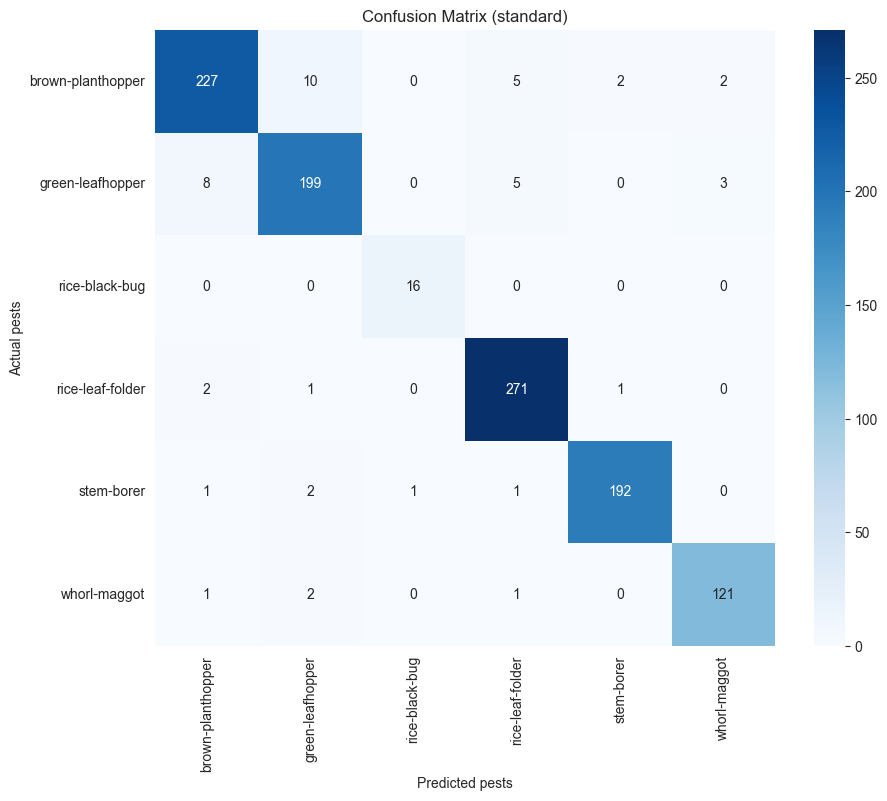

In [17]:
import torchvision.models as models

classes_names = train_set.classes
hardware = torch.device('cuda' if   torch.cuda.is_available() else 'cpu')
model_inference = PestClassifierEfficientNetV2M(num_classes=len(classes_names))
model_inference.load_state_dict(torch.load('models/EfficientNetV2/SEfficientNetV2-m_rice_pest_classificationV12.pt', map_location=hardware))
image_path = 'datasets/val/brown-planthopper/7 (758).jpg'
unrelated = 'unrelated_data/imagesz.jpg'

pest, confidence_score, over_all_scores = predict_single_image(model=model_inference, image_path=unrelated, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted pest is: {pest}")
print(f"Confidence: {confidence_score * 100:.2f}%")
print(f"Overall score: {over_all_scores}")

true, pred = eval_metrics(model_inference, test_loader, classes_names, hardware)